# Distance calculation


JAXScape makes landscape connectivity analysis fast and differentiable. Here we demonstrate how to compute different distance metrics on a graph and use automatic differentiation to identify which landscape pixels, if improved, would most increase connectivity—essential for connectivity conservation prioritization.

### Prerequisites
```bash
pip install jaxscape numpy matplotlib equinox
```

In [126]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jaxscape import GridGraph, LCPDistance, ResistanceDistance, RSPDistance

## Loading data

The landscape is represented as a **permeability raster** (the inverse of resistance), where each pixel value indicates how easily organisms move through that location. Higher permeability values represent easier movement, while lower values represent barriers. In this example, the raster contains binary values (0s and 1s).

!!! info
    JAXScape uses permeability rather than resistance because permeability has better numerical properties—infinite resistance (complete barrier) naturally maps to zero permeability, avoiding numerical issues.

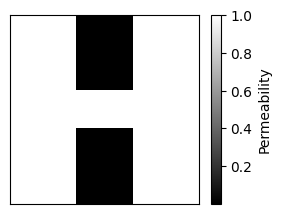

In [127]:
# Load permeability raster
permeability = (
    jnp.array(np.loadtxt("../data/permeability.csv", delimiter=",")) + 0.001
)  # Add small constant to allow for movement (for numerical stability)

# Visualize the permeability landscape
fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(permeability, cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
plt.colorbar(im, ax=ax, label="Permeability", shrink=0.7)
plt.tight_layout()
plt.show()

## Create graph

JAXScape converts the raster to a **grid graph** where pixels are nodes and edges connect neighbors with weights derived from the raster of permeability values.

In [128]:
# Construct grid graph from permeability raster
grid = GridGraph(grid=permeability, fun=lambda x, y: (x + y) / 2)

The `fun` parameter defines how to compute edge weights from neighboring pixel values. Here, we use the average of the two pixels, so that our graph is undirected.

## Define source pixel

A nodes in a `GridGraph` can be referenced by its (row, column) coordinates, or by its flattened index. Here, we compute distances from the top-left pixel to all other locations.

In [129]:
# Define source location (top-left corner)
source = grid.coord_to_index(jnp.array([0]), jnp.array([0]))

print(f"Source coordinates: (0, 0)")
print(f"Source node index: {source[0]}")

# Convert back to verify
source_coords = grid.index_to_coord(source)
print(f"Verification - coordinates: ({source_coords[0, 0]}, {source_coords[0, 1]})")

Source coordinates: (0, 0)
Source node index: 0
Verification - coordinates: (0, 0)


## Compute distance metrics

JAXScape currently offers three distance metrics:

`LCPDistance` finds the single optimal route (deterministic movement). `RSPDistance` considers multiple paths weighted by cost, with temperature parameter θ controlling stochasticity. `ResistanceDistance` treats the landscape as an electrical network, naturally accounting for all paths (suitable for gene flow).

In [130]:
from jaxscape.solvers import CholmodSolver


# Initialize distance metrics
distances = {
    "LCP Distance": LCPDistance(),
    "RSP Distance": RSPDistance(
        theta=0.01,  # Low temperature → more deterministic
        cost=lambda x: 1 / x,  # Cost inversely proportional to permeability
    ),
    "Resistance Distance": ResistanceDistance(solver=CholmodSolver()),
}

!!! warning "Solver Configuration"
    `ResistanceDistance` requires a linear solver, which significantly impacts both memory usage and computational speed. JAXScape provides two optimized solver options:
    
    - **PyAMG** (`PyAMGSolver`): Algebraic multigrid solver with moderate memory footprint
    - **Cholesky** (`CholmodSolver`): Faster but requires more memory
    
    **Installation** (Python 3.10-3.12 only):
    ```console
    uv add jaxscape --extra pyamg      # Install PyAMG solver
    uv add jaxscape --extra cholespy   # Install Cholesky solver
    uv add jaxscape --extra solvers    # Install both solvers
    ```
    
    !!! info "Optional solvers support"
        These optional solvers are not tested in CI/CD. The `cholespy` package does not provide wheels for Python 3.13+.
    
    **Default behavior:** If no solver is specified, JAXScape falls back to matrix inversion, which is very inefficient for large graphs (>5k nodes). Always specify a solver for production use.

In [131]:
distance_arrays = {}
for name, distance_metric in distances.items():
    print(f"Computing {name}...")

    # Compute distances
    dist_to_node = distance_metric(grid, source)

    # Convert from node values to 2D array and mask low-permeability areas
    dist_array = grid.node_values_to_array(dist_to_node.ravel())
    dist_array = dist_array * (permeability > 0.1)  # Mask barriers

    distance_arrays[name] = dist_array

Computing LCP Distance...
Computing RSP Distance...
Computing Resistance Distance...


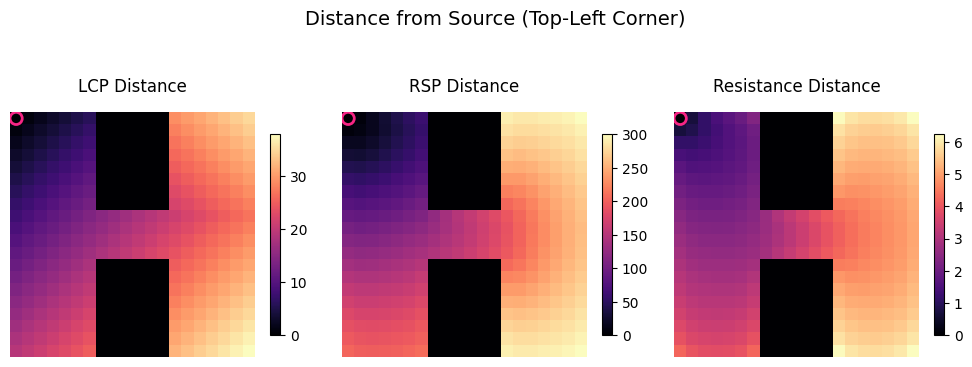

In [132]:
# Visualize all three distance metrics
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, (title, dist_array) in zip(axs, distance_arrays.items()):
    im = ax.imshow(dist_array, cmap="magma")
    ax.set_title(title, fontsize=12, pad=15)
    ax.axis("off")

    # Mark source location
    circle = plt.Circle(
        (0, 0), radius=0.5, fill=False, edgecolor="#f72585", linewidth=2
    )
    ax.add_patch(circle)

    plt.colorbar(im, ax=ax, shrink=0.6, label="")

fig.suptitle("Distance from Source (Top-Left Corner)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [133]:
fig.savefig("distances.png", dpi=300, transparent=True, bbox_inches="tight")

## Sensitivity analysis with automatic differentiation

JAXScape distance metrics are fully differentiable. This enables computing **gradients** of connectivity metrics with respect to the permeability matrix, revealing how changes in each pixel affect overall connectivity.

We'll calculate the gradient of **average path length (APL)**—the mean distance between all node pairs—with respect to permeability. The resulting gradient `∂APL/∂permeability` identifies connectivity bottlenecks across the landscape.

!!! tip "Interpreting sensitivity"
    Pixels with large negative gradients are high-priority restoration targets: improving permeability at these locations yields the greatest reduction in average path length, thus maximizing connectivity gain.

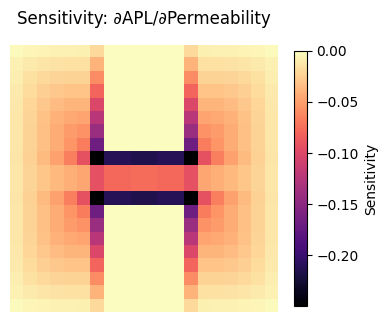

In [134]:
@eqx.filter_jit
def average_path_length(permeability, distance_metric):
    """Compute average path length across all node pairs.

    This is a global connectivity measure: lower values indicate
    better overall connectivity.
    """
    grid = GridGraph(permeability)
    dist = distance_metric(grid)
    return dist.sum() / grid.nv**2


# Create gradient function
grad_connectivity = jax.grad(average_path_length)
# Compute sensitivity (gradient)
sensitivities = grad_connectivity(permeability, LCPDistance())

# Mask barriers for visualization
sensitivities_masked = sensitivities * (permeability > 0.1)

fig, ax = plt.subplots(figsize=(4, 4))
# Sensitivity map
im = ax.imshow(sensitivities_masked, cmap="magma")
ax.set_title("Sensitivity: ∂APL/∂Permeability", fontsize=12, pad=15)
ax.axis("off")

plt.colorbar(im, ax=ax, shrink=0.7, label="Sensitivity")
plt.tight_layout()

You've learned JAXScape's core workflow: constructing grid graphs from rasters, computing distance metrics (LCP, RSP, Resistance), and using automatic differentiation for sensitivity analysis. The gradient-based approach identifies connectivity bottlenecks for data-driven conservation prioritization.